KIANA ASGARI

97100473

# INIT

In [ ]:
import numpy as np
import sys
import gym
import torch
import pylab
import random



import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from collections import deque
import torch.nn as nn
import torch.optim as optim


In [ ]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
n_action = env.action_space.n

# Model

implimenting DQN model

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, n_action):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_action)
        )

    def forward(self, x):
        return self.model(x)

implimenting self leaner agent

In [ ]:
class Agent():
    def __init__(self, input_dim, n_action):

        #parameter ha az site asli bardashte shodan
        self.render = False
        self.load_model = False

        self.input_dim = input_dim
        self.n_action = n_action

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.memory_size = 20000
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 5000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=self.memory_size)
        self.model = DQN(input_dim, n_action)
        self.model.apply(self.weights_init)
        self.DQN = DQN(input_dim, n_action)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        self.DQN.load_state_dict(self.model.state_dict())

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)



############################################################
    def train(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        dones = dones.astype(int)

        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.n_action).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.DQN(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        self.optimizer.zero_grad()

        loss = F.mse_loss(pred,target)
        loss.backward()

        self.optimizer.step()

# New Section

In [ ]:
model = DQN(input_dim, n_action)
agent = Agent(input_dim, n_action)
scores, episodes = [], []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# TRAIN

[EPISODE]: 1     score= 9.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[EPISODE]: 51     score= 17.0
[EPISODE]: 101     score= 134.0
[EPISODE]: 151     score= 181.0
[EPISODE]: 201     score= 153.0
[EPISODE]: 251     score= 500.0
[EPISODE]: 301     score= 112.0
[EPISODE]: 351     score= 500.0
[EPISODE]: 401     score= 500.0
[EPISODE]: 451     score= 500.0


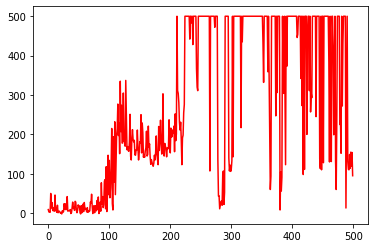

In [ ]:

for e in range(500):
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, input_dim])

    while True:
        if agent.render:
            env.render()

        action = agent.get_action(state)

        next_state, reward, done, info = env.step(action)
        reward = reward if not done or score == 499 else -10

        next_state = np.reshape(next_state, [1, input_dim])

        agent.memory.append((state, action, reward, next_state, done))

        if len(agent.memory) >= agent.train_start:
            agent.train()

        score += reward
        state = next_state

        if done:
            agent.DQN.load_state_dict(agent.model.state_dict())

            #score = score if score == 500 else score + 10
            scores.append(score)
            episodes.append(e)
            if e%50==0:
                print("[EPISODE]:", e+1, "    score=", score)
            break


pylab.plot(episodes, scores, 'r')


توجه!!
دلیل اینکه اخراش یکم احمق شده نمودار اینه که کران 500 برای اسکور گذاشتم و وقتی به اسکور مد نظر رسید برای اینکه حتما 500 بار اجزا بشه شبکه  رو متوقف نکردم!